In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_cma import analyze_checkpoint

from auctions.webutils import *

import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Magma256
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

output_notebook()


Loading BokehJS ...

In [2]:
sns.set(font_scale=2)

In [3]:
# load experiment
experiment = Experiment.objects.get(name='jun5outcome')

In [4]:
records = []
for run in tqdm(experiment.equilibriumsolverrun_set.all()):
    try:
        record = dict(game_name=run.game.name, potential=run.config.get('potential_function', 'None'), run_name=run.name, scale_coef=run.config.get('scale_coef', 'None'))

        # Get the last eval
        final_checkpoint = run.equilibriumsolverruncheckpoint_set.last()
        record = {**record, **analyze_checkpoint(final_checkpoint)}
        record['t'] = final_checkpoint.t

        ## TODO: Some assert statement that asserts that the evaluation has a reasonable number of samples, and not some stupid number like 10

        # Get NC information -> requires best responses
        try:
            ev_df = parse_run(run)
            nc = ev_df.query(f't == {final_checkpoint.t}')['ApproxNashConv'].max()
            record['NashConv'] = nc
        except:
            record['NashConv'] = 999_999_999

        records.append(record)
    except:
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.50it/s]


In [5]:
df = pd.DataFrame.from_records(records)
print(len(df))
print(df.columns)

45
Index(['game_name', 'potential', 'run_name', 'scale_coef', 'p0_utility',
       'p0_payment', 'p1_utility', 'p1_payment', 'total_welfare',
       'total_revenue', 'auction_lengths', 'common_allocations', 't',
       'NashConv'],
      dtype='object')


In [6]:
def variant(game_name):
    # TODO: Better done from reading the source config, but I'm lazy
    var_string = ''
    
    # Using + right now so it won't be silent if you have two+ 
    if 'hide' in game_name:
        var_string += 'hide'
    
    if 'signal' in game_name:
        var_string += 'signal'
    
    if 'base' in game_name:
        var_string += 'base'
    
    if 'memory' in game_name:
        var_string += 'memory'
        
    if 'reveal' in game_name:
        var_string += 'reveal'
        
    if 'undersell' in game_name:
        var_string += 'undersell'
    
    return var_string

def actual_name(game_name):
    return game_name.replace('_base', '').replace('_hide_demand', '').replace('_signal','').replace('.json','').replace('_memory', '').replace('_reveal', '').replace('_undersell', '')

df['variant'] = df['game_name'].apply(variant)
df['game'] = df['game_name'].apply(actual_name)

In [7]:
# # Does potential shaping work / do anything?
# plt.figure(figsize=(20,10))
# ax = sns.boxplot(data=df.query('potential == "None" or potential == "pricing"'), x='game', y='total_revenue', hue='scale_coef')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [8]:
df.groupby(['game', 'variant']).size()

game                    variant
jun5/jun5_0             base       3
                        hide       3
jun5/jun5_0_high_speed             3
jun5/jun5_1             base       3
                        hide       3
jun5/jun5_1_high_speed             3
jun5/jun5_2             base       3
                        hide       3
jun5/jun5_2_high_speed             3
jun5/jun5_3             base       3
                        hide       3
jun5/jun5_3_high_speed             3
jun5/jun5_4             base       3
                        hide       3
jun5/jun5_4_high_speed             3
dtype: int64

In [9]:
STATS = ['total_revenue', 'total_welfare', 'auction_lengths']

In [10]:
df = df.sort_values(['game', 'variant'])

In [11]:
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
for stat in STATS:
    base_stat = df.pivot_table(index='game', values=stat, aggfunc='mean', columns='variant')
    df[f'normalized_{stat}'] = df.apply(lambda x: x[stat] / base_stat.loc[x['game'], 'base'], axis=1)

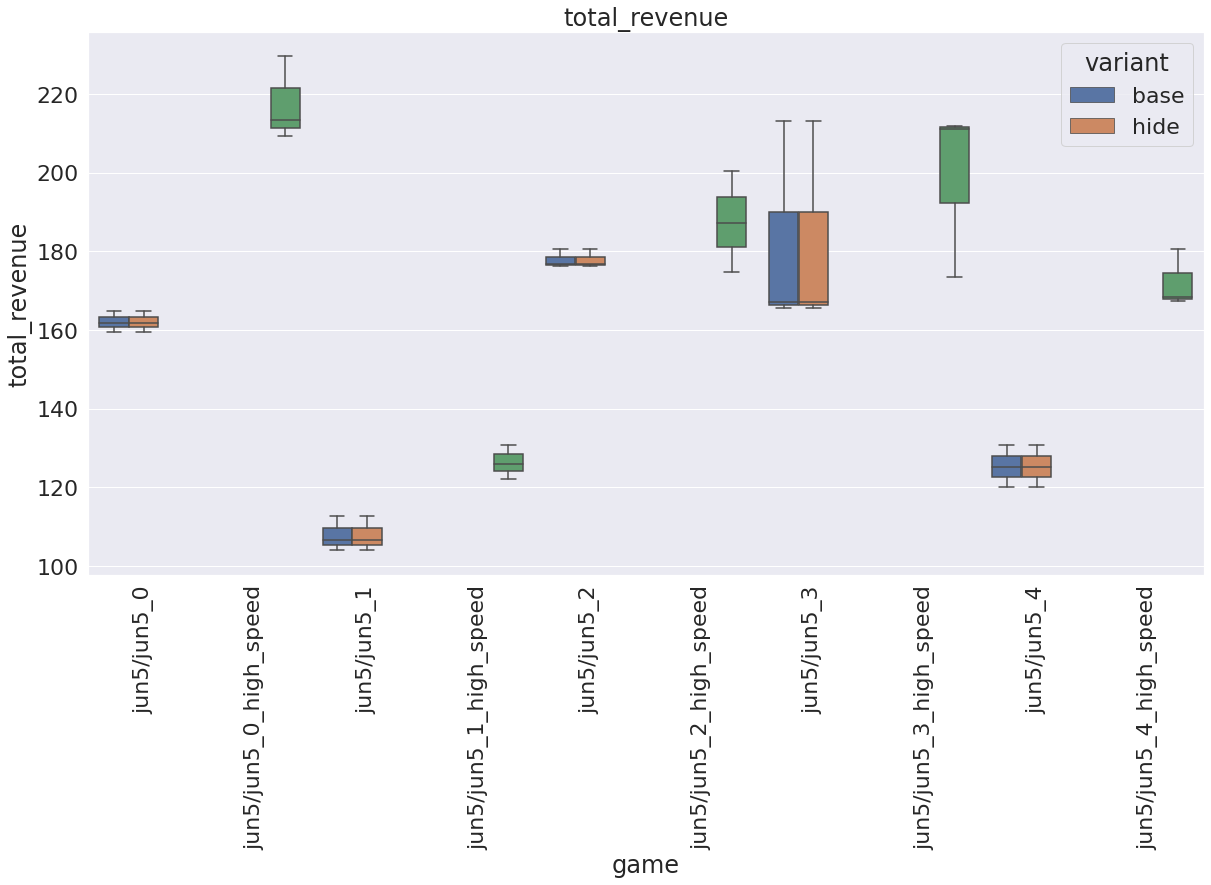

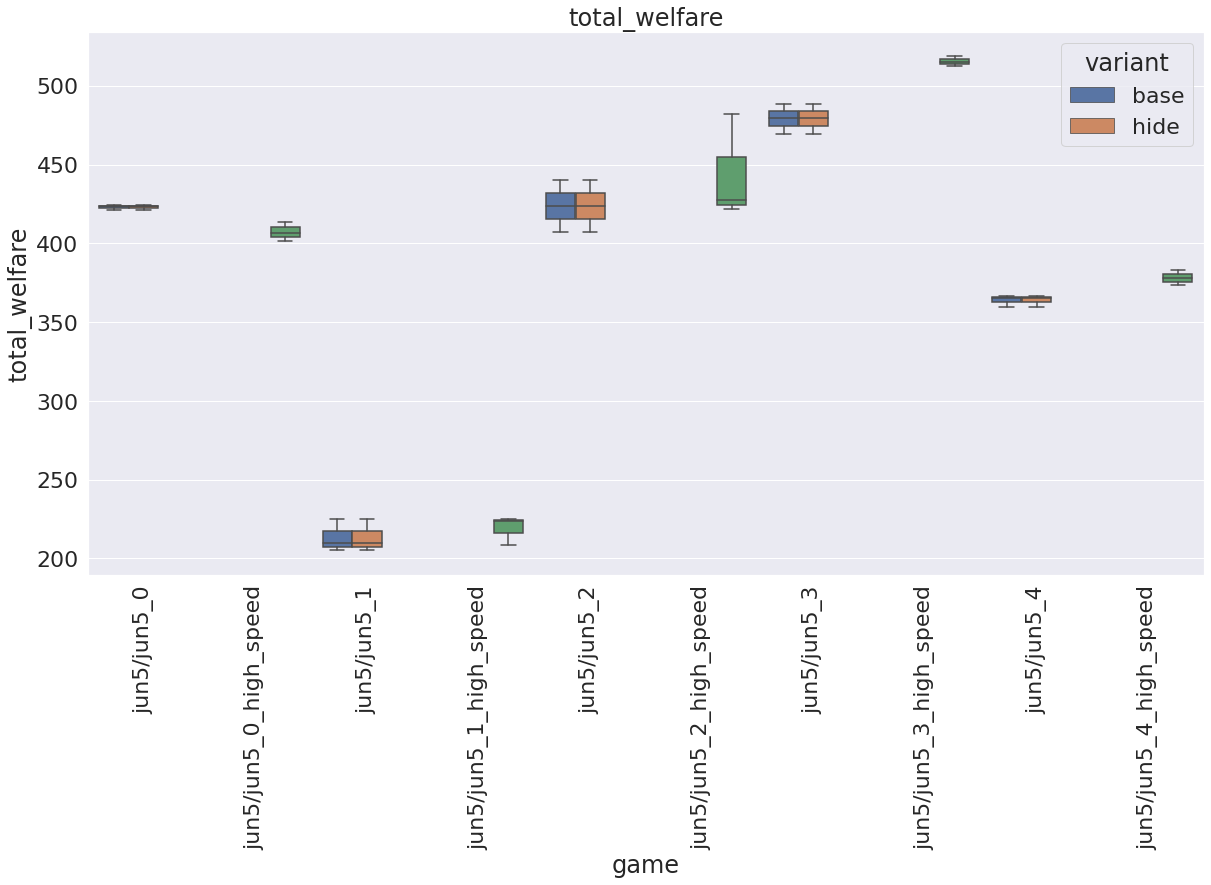

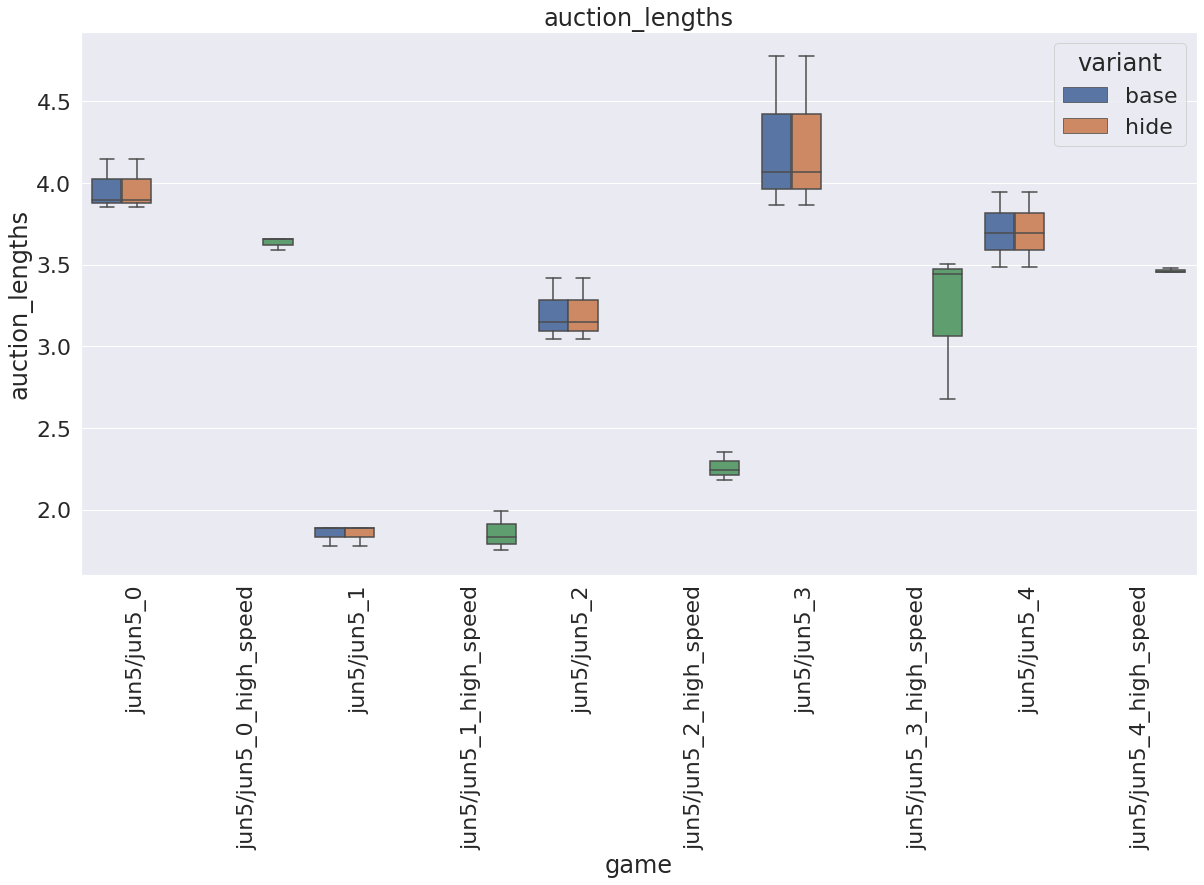

In [12]:
NORMALIZED = False
for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(data=df, x='game', y=stat, hue='variant')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.title(f"{stat}")

In [ ]:
# TODO: Compute signaling metric. What fraction of trajectories include a bid for the signalling product? (Is that flawed? What if the signal is for a rare event?)

In [ ]:
### Rerun evals
from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name='jan5').delete()
for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name='jun5'):
    experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
    run_name = e.checkpoint.equilibrium_solver_run.name
    t = e.checkpoint.t
    dispatch_eval_database(experiment_name, run_name, t, None, None)
